In [31]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
import dataset as ds
from matplotlib.patches import Patch
import torch
import torch.nn as nn
from collections import OrderedDict
import sys
sys.path.append(os.path.join(os.getcwd(), "models"))
from models.unet import *
from models.majority_classifier import *

In [32]:
path = "./data"
#ds = ds.DFC20(path, subset="test", use_s1 = True, use_s2_hr=False, normalize=True) #s1
ds = ds.DFC20(path, subset="test", use_s1 = False, use_s2_hr=True, normalize=True) #s2

[Load]: 100%|██████████| 1160/1160 [00:00<00:00, 289004.61it/s]

loaded 1160 samples from the DFC20 subset test


In [6]:
def predict_patch(model, image):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradients needed during inference
        # Convert to tensor if it's not already
        if isinstance(image, np.ndarray):
            image = torch.tensor(image, dtype=torch.float32)
        # Check the shape and ensure it's in the correct format [batch_size, channels, height, width]
        if image.ndim == 3:  # If it's a single image (HxWxC)
            image = image.unsqueeze(0)  # Add batch dimension
        # Forward pass through the model
        output = model(image)  # Assuming the model's output shape is [batch_size, num_classes, H, W]
        # Apply argmax to get the predicted class for each pixel
        pred = torch.argmax(output, dim=1).squeeze(0)  # Get the class with max score for each pixel
        # Convert to numpy array for visualization
        pred = pred.cpu().numpy()

    return pred

In [28]:
def visualize_rgb_prediction_label(patch, model=None, model_is_majority=False, sensor='s2'):
    class_info = ds.class_info

    # Extract appropriate bands for visualization
    if sensor == 's2':
        image = patch['image'][:3]  # RGB bands for Sentinel-2
    elif sensor == 's1':
        image = patch['image'][:2]  # VV and VH for Sentinel-1
        image = (image - image.min(axis=(1, 2), keepdims=True)) / \
                (image.max(axis=(1, 2), keepdims=True) - image.min(axis=(1, 2), keepdims=True) + 1e-6)
        r, g = image[0], image[1]
        b = (r + g) / 2
        image = np.stack([r, g, b], axis=0)
    else:
        raise ValueError("sensor must be either 's1' or 's2'")

    # Apply contrast stretching
    image = np.clip((image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6), 0, 1)
    image = np.clip(image * 1.5, 0, 1)

    # Create a figure with three subplots
    fig, ax = plt.subplots(1, 3, figsize=(14, 6))

    # Plot the image
    ax[0].imshow(np.transpose(image, (1, 2, 0)))  # Convert to HxWxC
    ax[0].set_title('Image')
    ax[0].axis('off')

    # Create a custom colormap for the labels
    from matplotlib.colors import ListedColormap, BoundaryNorm
    colors = ['black'] + [color for _, color in class_info.values()]  # Add black for -1
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries=np.arange(-1, len(class_info)+1), ncolors=len(colors))

    # Get prediction
    if model is not None:
        model.eval()
        with torch.no_grad():
            input_tensor = torch.tensor(patch['image']).unsqueeze(0).to(next(model.parameters()).device)
            output = model(input_tensor)

            if model_is_majority:
                if output.dim() == 4:
                    output = output.squeeze(-1).squeeze(-1)
                predicted_class = output.argmax(dim=1).item()
                H, W = patch['label'].shape
                pred = np.full((H, W), predicted_class, dtype=np.int32)
            else:
                output = torch.argmax(output, dim=1)
                pred = output.squeeze(0).cpu().numpy().astype(np.int32)
    else:
        pred = np.full_like(patch['label'], fill_value=-1, dtype=np.int32)  # Use -1 for no prediction

    # Show prediction with special color for -1
    ax[1].imshow(pred, cmap=cmap, norm=norm)
    ax[1].set_title('Prediction')
    ax[1].axis('off')

    # Show ground truth
    ax[2].imshow(patch['label'], cmap=cmap, norm=norm)
    ax[2].set_title('Ground Truth')
    ax[2].axis('off')

    # Create legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='black', edgecolor='black', label='No prediction')] + \
                      [Patch(facecolor=color, edgecolor='black', label=name) for name, color in class_info.values()]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Classes")

    plt.tight_layout()
    plt.show()


(2, 256, 256)
ROIs0000_autumn_s2_BandarAnzali_p384.tif
[0. 2. 3. 4. 5.]
4


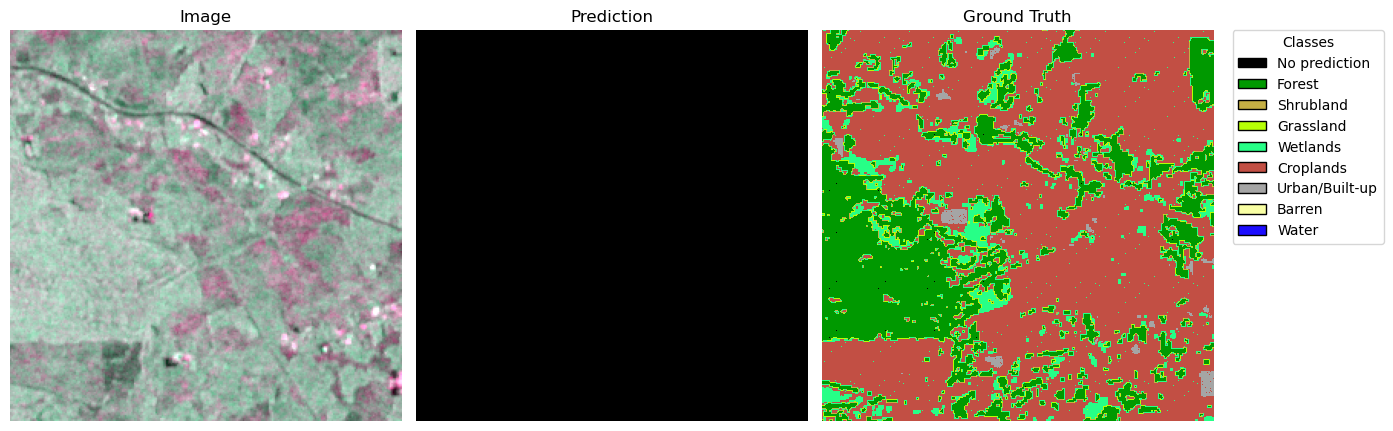

<All keys matched successfully>

In [29]:
patch = ds.__getitem__(284) # 260, ..., 280, ...
print(patch["image"].shape)
print(patch["id"])
print(np.unique(patch["label"]))
print(patch["majority_class"])

model_path = 'trained_models/unet_s2_base.pth'
model = UNetSmall(n_channels=4)  # n_channels based on model
model.load_state_dict(torch.load(model_path))

visualize_rgb_prediction_label(patch, model=None, sensor='s1') #s1
#visualize_rgb_prediction_label(patch, model=model, sensor='s2') #s2

model_encoder_majority_path = 'trained_models/majority_class_classifier_s2_auto-1.pth'
model_encoder_majority = AutoSizedMajorityClassifier(
    encoder=model.encoder,
    feature_level=-1,   # bottleneck output -1, or -2 for previous, etc.
    target_head_params=500
)
model_encoder_majority.load_state_dict(torch.load(model_encoder_majority_path))

#visualize_rgb_prediction_label(patch, model=model_encoder_majority, model_is_majority=True)

In [ ]:
def compute_receptive_field(model, input_shape=(1, 4, 128, 128), output_pos=(0, 0, 64, 64), threshold_factor=0.01, visualize=True):
    model.eval()
    x = torch.zeros(input_shape, requires_grad=True)

    # Forward pass
    out = model(x)

    # Create a 1-hot signal at a single output pixel
    mask = torch.zeros_like(out)
    mask[output_pos] = 1.0

    # Backward pass from one output pixel
    out.backward(gradient=mask)

    # Sum absolute gradients over channels to get influence map
    grad_mask = x.grad[0].abs().sum(dim=0)  # shape: (H, W)

    # Compute total receptive field (all non-zero gradients)
    influenced_coords = torch.nonzero(grad_mask > 0, as_tuple=False)
    if len(influenced_coords) == 0:
        rf_size = (0, 0)
    else:
        min_yx = influenced_coords.min(dim=0).values
        max_yx = influenced_coords.max(dim=0).values
        rf_size = (max_yx[0] - min_yx[0] + 1, max_yx[1] - min_yx[1] + 1)

    # Compute effective receptive field using threshold on grad_mask
    threshold = threshold_factor * grad_mask.max()
    effective_coords = torch.nonzero(grad_mask > threshold * grad_mask.max(), as_tuple=False)
    if len(effective_coords) == 0:
        erf_size = (0, 0)
    else:
        min_yx_eff = effective_coords.min(dim=0).values
        max_yx_eff = effective_coords.max(dim=0).values
        erf_size = (max_yx_eff[0] - min_yx_eff[0] + 1, max_yx_eff[1] - min_yx_eff[1] + 1)

    if visualize:
        grad_log = np.log1p(grad_mask * 100) # scale for better visibility
                            
        plt.imshow(grad_log, cmap='hot')
        plt.title('Receptive Field Heatmap')
        plt.colorbar()
        plt.show()
    
    print(f"Receptive field size: {rf_size}")
    print(f"Effective receptive field size: {erf_size}") # cuzrrently 1% of max activation

    return rf_size, erf_size, grad_mask

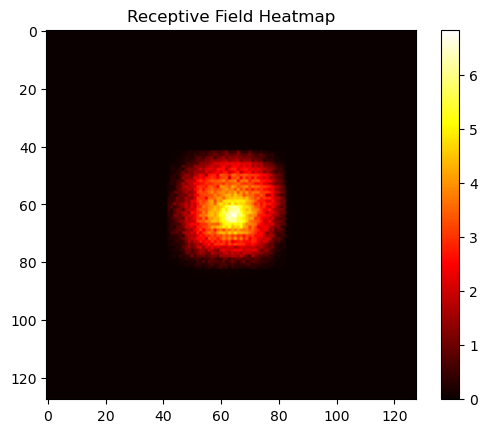

Receptive field size: (tensor(49), tensor(49))
Effective receptive field size: (tensor(14), tensor(14))


In [35]:
model_path = 'trained_models/unet_s2_base.pth'
model = UNetSmall(n_channels=4)  # n_channels based on model
model.load_state_dict(torch.load(model_path))
input_shape=(1, 4, 128, 128)
output_pos=(0, 0, 64, 64)
#input_shape=(1, 4, 17, 17)
#output_pos=(0, 0, 9, 9)
rf_size, erf_size, grad_mask = compute_receptive_field(model, input_shape, output_pos) # should output of this be symmetric?

In [49]:
def compute_encoder_receptive_fields(encoder, input_shape=(1,4,128,128), threshold_factor=0.01, visualize=False):
    encoder.eval()
    x = torch.zeros(input_shape, requires_grad=True)

    features = encoder(x)
    results = []

    for i, feat in enumerate(features):
        print(f"Stage {i}: feature shape = {feat.shape}")

        if feat.shape[2] == 0 or feat.shape[3] == 0:
            results.append({'stage': i, 'rf': (0,0), 'effective_rf': (0,0)})
            continue

        grad_mask = torch.zeros_like(feat)
        center_y = feat.shape[2] // 2
        center_x = feat.shape[3] // 2
        grad_mask[0, :, center_y, center_x] = 1.0  # all channels at center pixel

        encoder.zero_grad()
        if x.grad is not None:
            x.grad.zero_()

        try:
            feat.backward(gradient=grad_mask, retain_graph=True)
        except RuntimeError as e:
            print(f"Backward failed at stage {i}: {e}")
            results.append({'stage': i, 'rf': (0,0), 'effective_rf': (0,0)})
            continue

        grad = x.grad[0].abs().sum(dim=0)

        coords = torch.nonzero(grad > 0, as_tuple=False)
        if coords.shape[0] == 0:
            rf = (0, 0)
        else:
            min_yx = coords.min(dim=0).values
            max_yx = coords.max(dim=0).values
            rf = (max_yx - min_yx + 1).tolist()

        eff_coords = torch.nonzero(grad > threshold_factor * grad.max(), as_tuple=False)
        if eff_coords.shape[0] == 0:
            erf = (0, 0)
        else:
            min_eff = eff_coords.min(dim=0).values
            max_eff = eff_coords.max(dim=0).values
            erf = (max_eff - min_eff + 1).tolist()

        if visualize:
            import matplotlib.pyplot as plt
            import numpy as np
            plt.figure()
            plt.imshow(np.log1p(grad.cpu().numpy() * 100), cmap='hot')
            plt.title(f'Stage {i} Receptive Field Heatmap\nFull RF: {rf}, Effective RF: {erf}')
            plt.colorbar()
            plt.show()

        results.append({'stage': i, 'rf': rf, 'effective_rf': erf})

    return results


Stage 0: feature shape = torch.Size([1, 32, 64, 64])


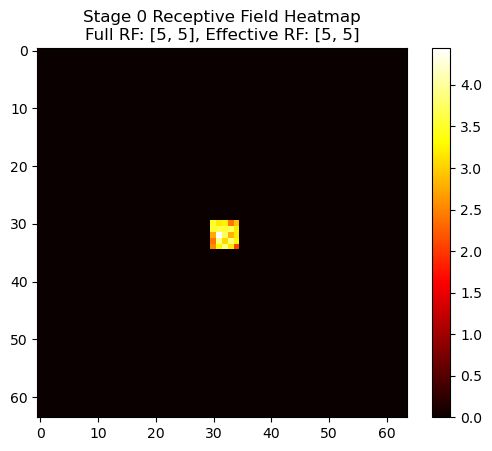

Stage 1: feature shape = torch.Size([1, 64, 32, 32])


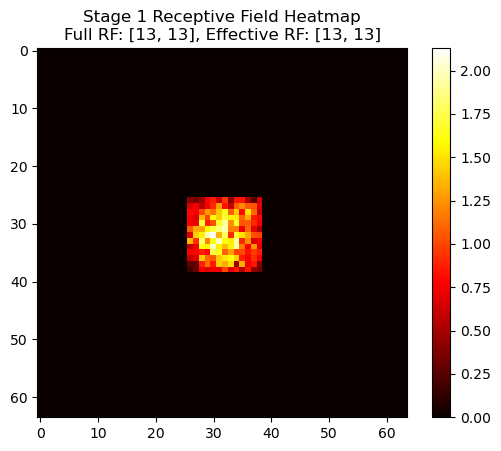

Stage 2: feature shape = torch.Size([1, 128, 16, 16])


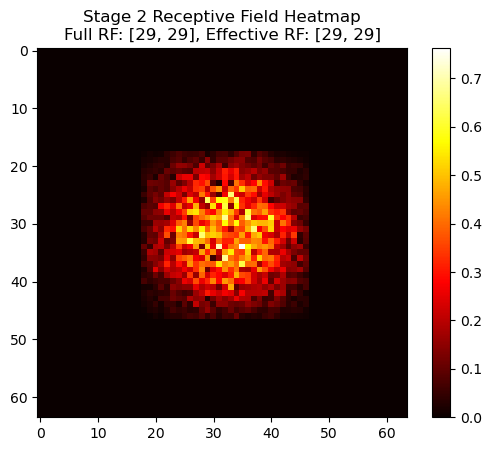

Stage 0: RF = [5, 5], Effective RF = [5, 5]
Stage 1: RF = [13, 13], Effective RF = [13, 13]
Stage 2: RF = [29, 29], Effective RF = [29, 29]


In [50]:
encoder = EncoderSmall(in_channels=4)
rf_info = compute_encoder_receptive_fields(encoder, input_shape=(1, 4, 64, 64), visualize=True)

for r in rf_info:
    print(f"Stage {r['stage']}: RF = {r['rf']}, Effective RF = {r['effective_rf']}")